In [1]:
import umap
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.preprocessing import StandardScaler

import seaborn as sns

# plt.ion()
# %matplotlib widget

In [2]:
OUTPUT_DIM = 2

In [3]:
def load_embbed(pickle_path: str) -> tuple:
    data = np.load(pickle_path, allow_pickle=True).tolist()
    print(data.keys())
    file_refs = data['fnames']
    embeds    = data['embeddings']
    labels    = data['labels']
    classes   = data['classes']

    embeds = np.vstack(embeds)
    labels = np.vstack(labels)

    return file_refs, embeds, labels, classes

def plot_3d_data(data, labels):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], c=labels)
    plt.show()


def visualize_embedding(data, **kwargs):
    all_classes = sorted(list(data['classes']))
    color_palette = sns.color_palette("tab20", len(all_classes))
    class_to_color = {cls: color_palette[i] for i, cls in enumerate(all_classes)}

    embeddings = data['embeddings']
    labels = data['labels']
    model_name = data['model']
    classes = data['classes']

    # Map labels (integers) to corresponding class names
    class_names = [classes[label] for label in labels]
        
    # Get colors for each point
    colors = [class_to_color[cls] for cls in class_names]

    reducer = umap.UMAP(n_components=3, **kwargs)
    embeddings    = StandardScaler().fit_transform(embeddings)
    embeddings_2d = reducer.fit_transform(embeddings)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(embeddings_2d[:,0], embeddings_2d[:,1], embeddings_2d[:,2], c=labels)
    plt.title(model_name)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    
    plt.legend(labels=class_names)
    plt.tight_layout()
    #plt.savefig("embedding_visualization.png", dpi=300, bbox_inches='tight')
    plt.show()

# UNI

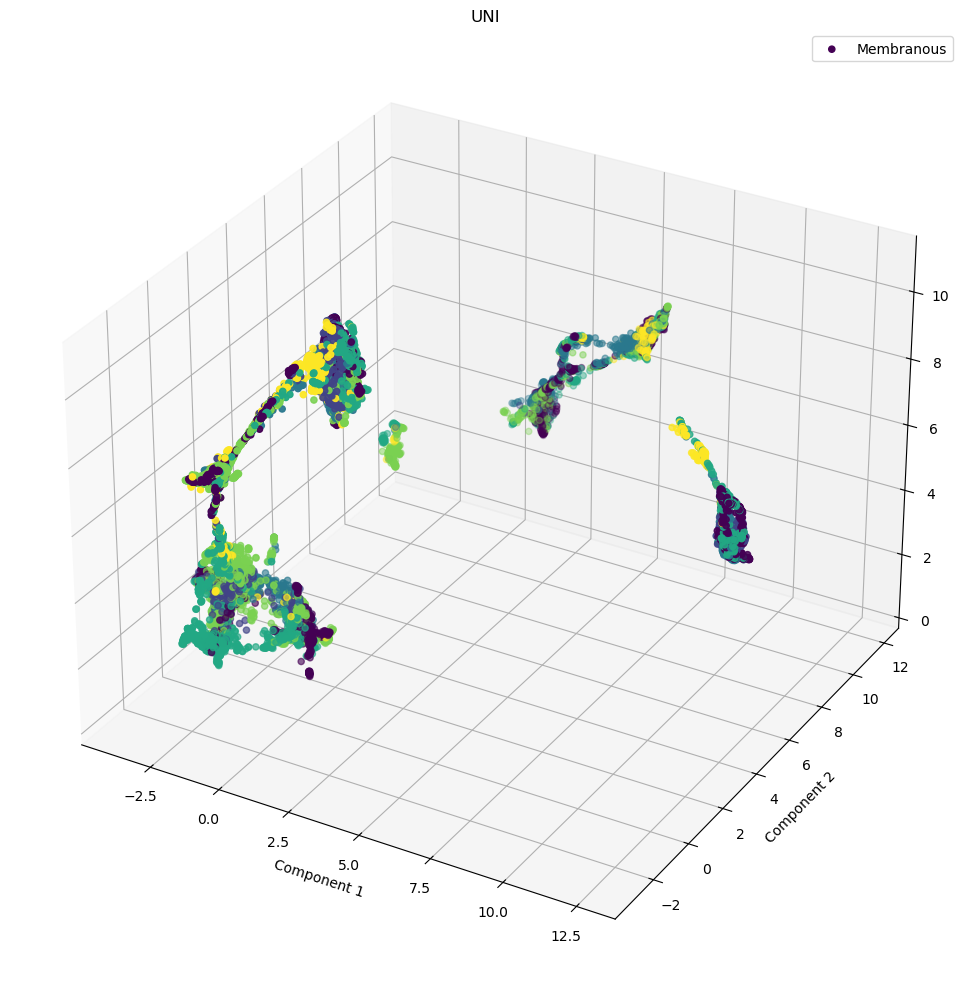

In [5]:
data = np.load("../extracted-embeddings/UNI.npy", allow_pickle=True).item()
visualize_embedding(data, n_neighbors=50, min_dist=0.1,metric='cosine')

# UNI2

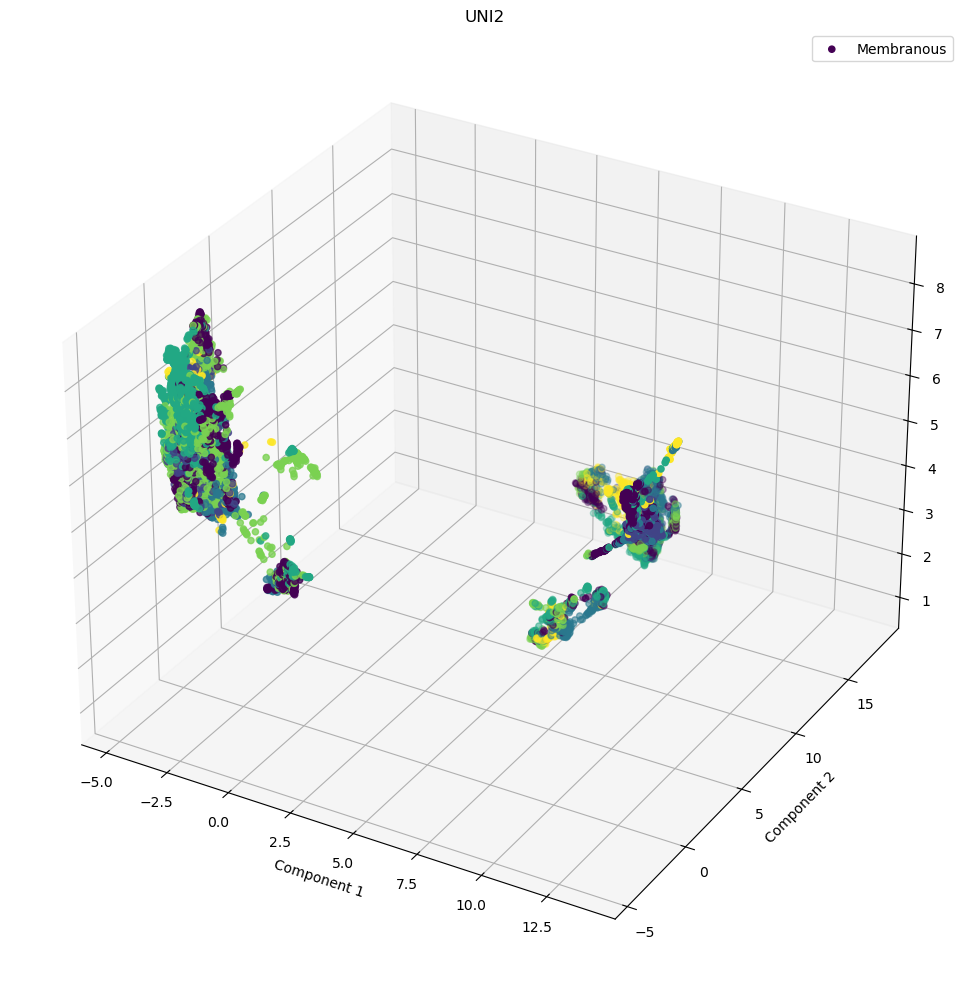

In [6]:
data = np.load("../extracted-embeddings/UNI2.npy", allow_pickle=True).item()
visualize_embedding(data, n_neighbors=50, min_dist=0.1,metric='cosine')

# Phikon

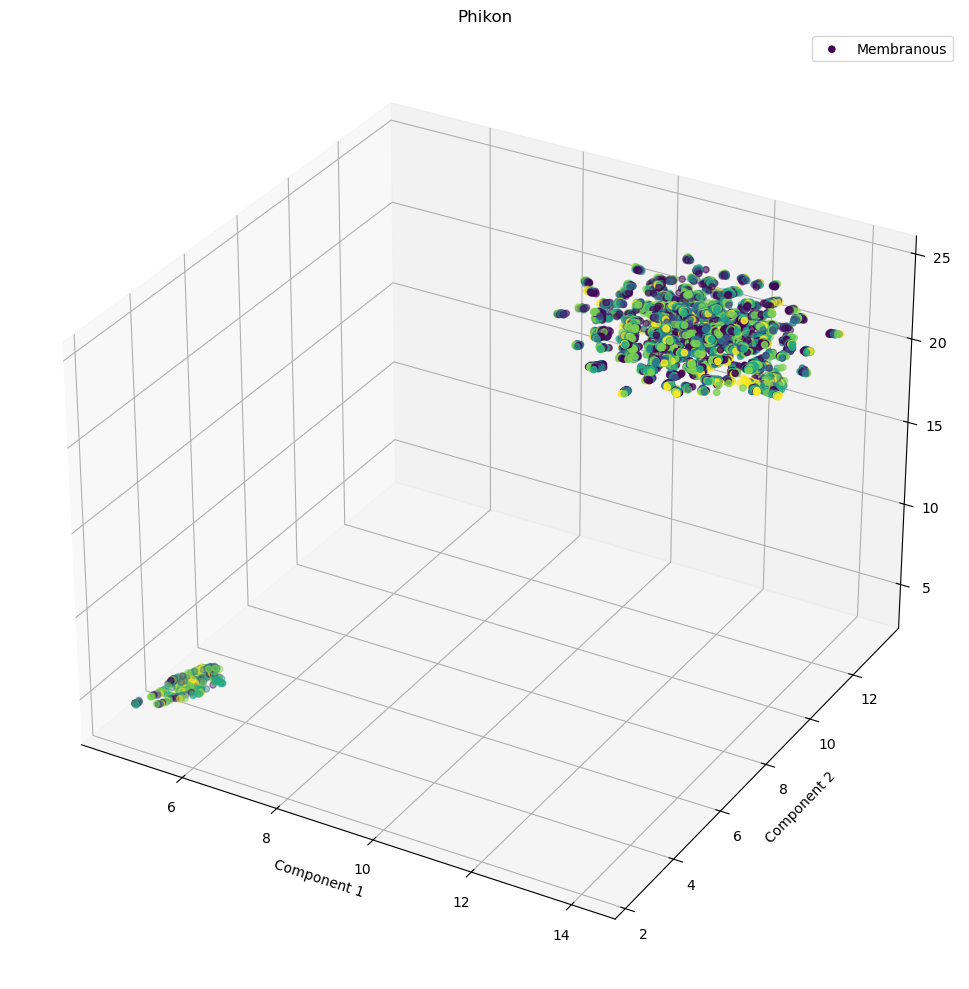

In [7]:
data = np.load("../extracted-embeddings/Phikon.npy", allow_pickle=True).item()
visualize_embedding(data, n_neighbors=50, min_dist=0.1,metric='cosine')

# PhikonV2

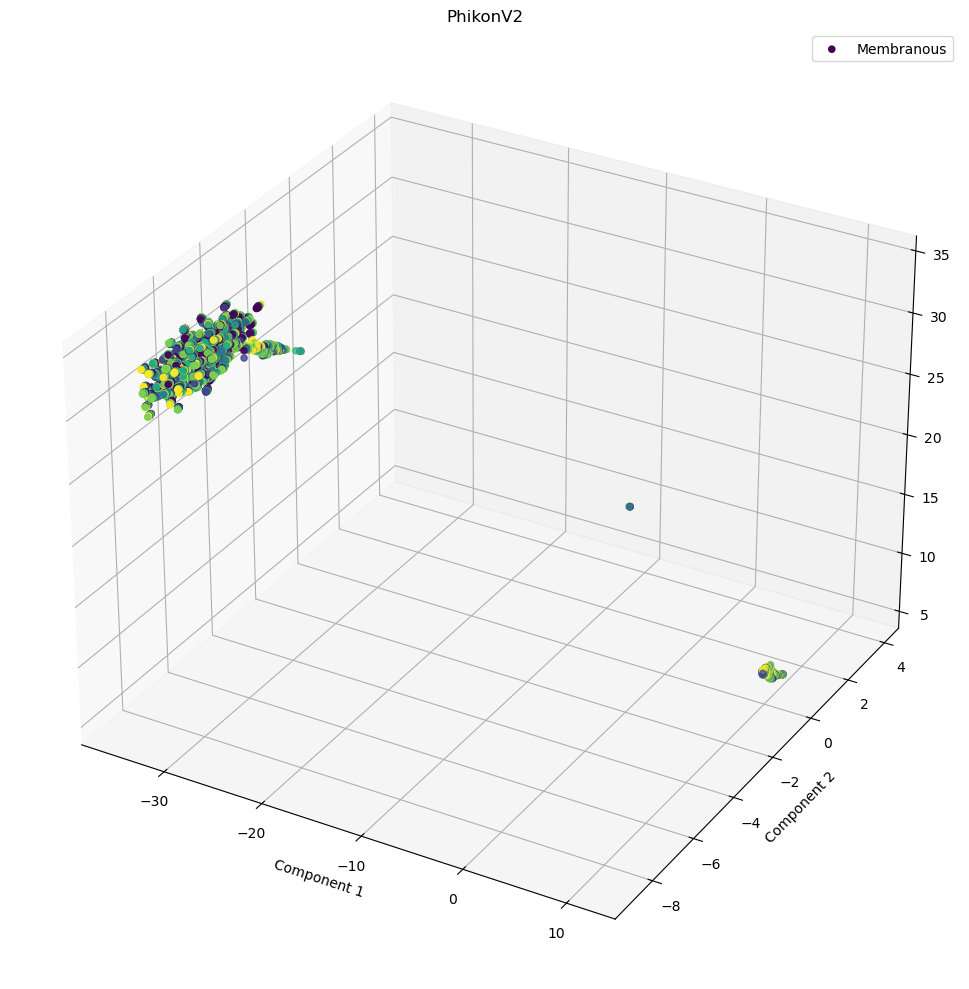

In [8]:
data = np.load("../extracted-embeddings/PhikonV2.npy", allow_pickle=True).item()
visualize_embedding(data, n_neighbors=50, min_dist=0.1,metric='cosine')